# Climate Change Analysis

Unless you've been living under a rock for the past thirty plus years, you've heard how much of an existential threat climate change is expected to be. From more devastating hurricanes, to uncontrollable wildfires, to rising sea levels, we know the world is changing, and not in a good way. 

However we always seem to be just not yet ready to commit to fighting climate change. Particularly in the US. Whether renewable energy is seen as too expensive, alternative transportation as inconvenient, or new corporate pollution restrictions as government overreach, the costs just don't seem to weigh enough for rapid measures to be taken. 

But how long do we have? Can we afford to keep pushing off the inevitable, or is it already too late. These are the questions I seek to answer in this notebook.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sea-level-change/sea_levels_2015.csv
/kaggle/input/us-natural-disaster-declarations/us_disasters_m5.csv
/kaggle/input/us-natural-disaster-declarations/us_disaster_declarations.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv
/kaggle/input/global-cause-of-the-deaths-other-than-diseases/Caused of Deaths.csv
/kaggle/input/natural-disaster-data/economic-damage-from-natural-disasters.csv
/kaggle/input/natural-disaster-data/number-of-natural-disaster-events.csv
/kaggle/input/mauna-loa-carbon-dioxide-data-19742021/CO2_1974_2021.csv


# Carbon Dioxide Forecast

The believed underlying factor driving climate change is carbon dioxide emissions into the atmosphere. Naturally then, it makes sense to begin our analysis here by predicting future levels of carbon emissions and then looking at the potential negative effects of those emission levels.

In [2]:
co2 = pd.read_csv('/kaggle/input/mauna-loa-carbon-dioxide-data-19742021/CO2_1974_2021.csv')
co2['Date'] = pd.to_datetime(co2['Date'])
co2.drop(['Unnamed: 7','Unnamed: 8','Unnamed: 9'], axis=1, inplace=True)
co2.set_index('Date', inplace=True)
co2 = co2.resample(rule='MS').mean()
co2['Year'] = pd.DatetimeIndex(co2.index).year
co2['CO2_PPM'].fillna(method='ffill', inplace=True)
co2_ts = co2[['CO2_PPM']]
co2['CO2_Rolling'] = co2['CO2_PPM'].rolling(12).mean()
co2.dropna(subset=['CO2_Rolling'], inplace=True)

fig = px.line(co2, x=co2.index, y='CO2_PPM', title='CO2 Parts Per Million 1974-2021', 
              labels={'CO2_PPM':'CO2 PPM'})

fig.show()

Here is a graph a CO2 levels in the atmosphere measured every month from 1974 through March 2021. We can see it has a clear upward trend with very strong seasonality. This makes it a prime candidate for the Seasonal ARIMA model to forecast.

In [3]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


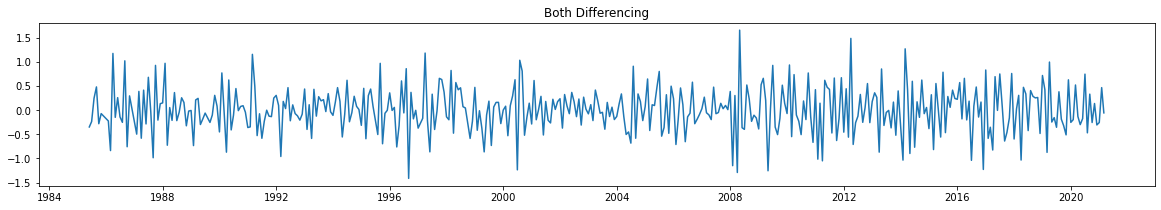

Stationarity Test Both Differencing: Test Statistic   -8.113695e+00
p-value           1.206752e-12
Lags Used         1.300000e+01
Observations      4.120000e+02
dtype: float64


In [4]:
diff2 = co2.diff().diff(12).dropna()

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(diff2.CO2_PPM)
ax.set_title('Both Differencing')
plt.show()

result1 = adfuller(diff2['CO2_PPM'])
adtest1 = pd.Series(result1[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Observations'])

print('Stationarity Test Both Differencing:', adtest1)

First I take both the non-seasonal and the seasonal difference of the series to make it stationary. This graph looks like white noise and the p-value is much less than 0.05 so this looks like a stationary series. In the model this will correspond to d=1 and D=1.

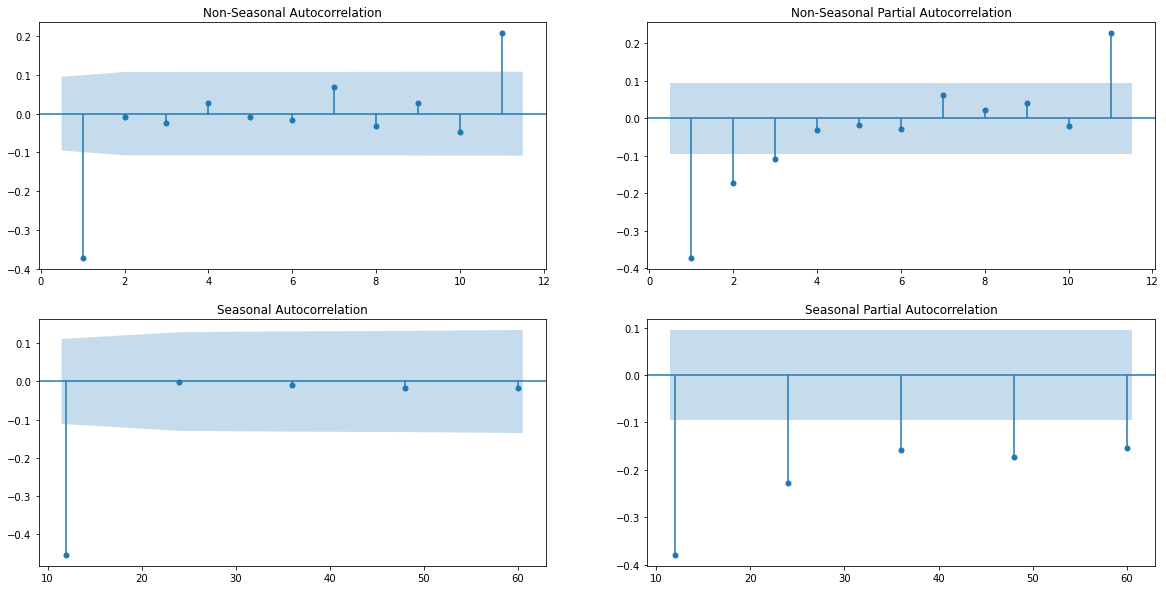

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plot_acf(diff2['CO2_PPM'], lags=11, zero=False, title='Non-Seasonal Autocorrelation', ax=ax[0,0])
plot_pacf(diff2['CO2_PPM'], lags=11, zero=False, title='Non-Seasonal Partial Autocorrelation', ax=ax[0,1])

plot_acf(diff2['CO2_PPM'], lags=[12, 24, 36, 48, 60], zero=False, title='Seasonal Autocorrelation', ax=ax[1,0])
plot_pacf(diff2['CO2_PPM'], lags=[12, 24, 36, 48, 60], zero=False, title='Seasonal Partial Autocorrelation', ax=ax[1,1])


plt.show()

Using the ACF and PACF plots I'll find the remaining parameters. The non-seasonal plots make it clear that the model should just have an MA term and no AR term since the PACF tapers off while the ACF shuts off abruptly. I'll try both q=1 and q=2 to see which one works the best. The seasonal plots tell the same thing except only one ACF lag is significant so Q=1.

In [6]:
order=(0, 1, 2)
sorder=(0, 1, 1, 12)

sarima = SARIMAX(co2.CO2_PPM, order=order, seasonal_order=sorder, trend='c')

c_model = sarima.fit(maxiter=200)

c_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              CO2_PPM   No. Observations:                  552
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -167.658
Date:                              Wed, 05 Jan 2022   AIC                            345.315
Time:                                      17:51:12   BIC                            366.764
Sample:                                  04-01-1975   HQIC                           353.704
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      2.172      0.030       0.000       0.004
ma.L1         -0.4375      0.039    -11.125      0.000      -0.515      -0.360
ma.L2         -0.0855      0.041     -2.081      0.037      -0.166      -0.005
ma.S.L12      -0.8763      0.024    -36.499      0.000      -0.923      -0.829
sigma2         0.1055      0.005     19.826      0.000       0.095       0.116
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                23.58
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best prediction based on AIC comes when q=2 and the trend is set equal to a constant. Now let's check this model and use it to make a forecast.

Mean Absolute Percent Error: 0.0006755364121536285


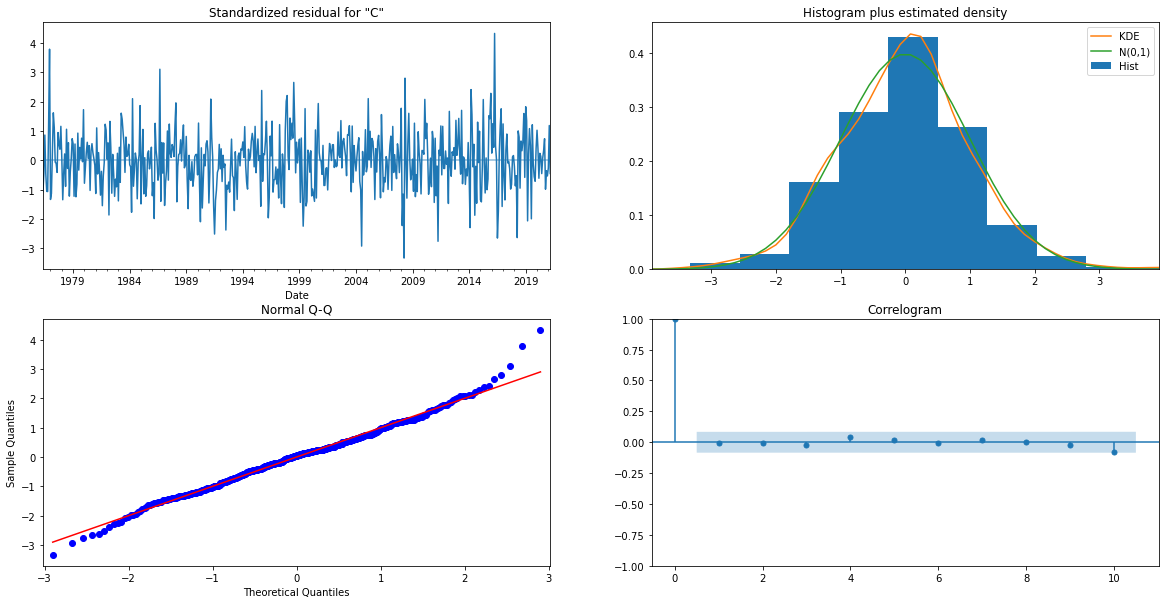

In [7]:
forecast = c_model.get_prediction(start=-113)
fig1 = px.line(co2, x=co2.index, y=co2.CO2_PPM, width=750, height=400, title='In-Sample Predictions', labels={'CO2_PPM':'CO2 PPM'})
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.show()

def mape(fc, true):
    mape = np.mean((np.abs(fc-true)/np.abs(true)))
    return mape

acc = mape(forecast.predicted_mean, co2['CO2_PPM'].iloc[-240:])
print('Mean Absolute Percent Error:', acc)

c_model.plot_diagnostics(figsize=(20, 10))
plt.show()


The predictions on the test set look very good with just 0.06% mean absolute error. The diagnostics also look alright as the residuals seem to be uncorrelated, but they could be a bit closer to normally distributed.

In [8]:
fc = c_model.get_forecast(steps=240)
co2_pred_mean = fc.predicted_mean

fig1 = px.line(co2, x=co2.index, y=co2.CO2_PPM, title='Predicted CO2 Levels Through 2040', labels={'CO2_PPM':'CO2 PPM'})
fig1.add_scatter(x=fc.predicted_mean.index, y=fc.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=fc.predicted_mean.index, y=fc.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=fc.predicted_mean.index, y=fc.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.show()

Finally I make my predictions for the next 20 years. This prediction seems to make sense as it follows the same trend and seasonality as the rest of the time series. It looks like unless powerful industrial nations take action soon, CO2 levels will rise by about 60 ppm over the next 20 years. But what does that mean? Is that bad? Let's forecast the global average temperature over the same time period using CO2 as an exogenous variable and see what happens.

# Global Average Temperature Forecast

There is a consensus among the scientific community that a temperature increase of 1.5 degrees celsius from pre-industrial levels (pre 1900) could lead to disastrous consequences across the world, and an increase of 2 degrees is essentially the point of no return. Let's use the CO2 data and historical temperature data to see how close we get to those kinds of increases within the next 20 years.


In [9]:
co2_levels = pd.concat([co2['CO2_PPM'], co2_pred_mean])
diff_co2_lvls = pd.DataFrame()
diff_co2_lvls['Forecasted'] = co2_levels['2016-01-01':]

diff_co2_lvls['LowBound'] = fc.conf_int().iloc[:,0]
diff_co2_lvls['LowBound'].fillna(diff_co2_lvls['Forecasted'], inplace=True)
diff_co2_lvls['UpBound'] = fc.conf_int().iloc[:,1]
diff_co2_lvls['UpBound'].fillna(diff_co2_lvls['Forecasted'], inplace=True)
diff_co2_lvls['Shut_Off'] = np.nan

so = []
for index, item in diff_co2_lvls.iterrows():
    if index > pd.to_datetime('2021-03-01'):
        so.append(420)
    else:
        so.append(np.nan)

diff_co2_lvls['Shut_Off'] = so
diff_co2_lvls['Shut_Off'].fillna(diff_co2_lvls['Forecasted'], inplace=True)

fill_list = co2['CO2_Rolling'].loc['2016-01-01':'2016-12-01']

diff_co2_lvls['Forecast_Rolling'] = diff_co2_lvls['Forecasted'].rolling(12).mean()
diff_co2_lvls['Forecast_Rolling'].fillna(fill_list, inplace=True)
diff_co2_lvls['UpBound_Rolling'] = diff_co2_lvls['UpBound'].rolling(12).mean()
diff_co2_lvls['UpBound_Rolling'].fillna(fill_list, inplace=True)
diff_co2_lvls['LowBound_Rolling'] = diff_co2_lvls['LowBound'].rolling(12).mean()
diff_co2_lvls['LowBound_Rolling'].fillna(fill_list, inplace=True)
diff_co2_lvls['SO_Rolling'] = diff_co2_lvls['Shut_Off'].rolling(12).mean()
diff_co2_lvls['SO_Rolling'].fillna(fill_list, inplace=True)
diff_co2_lvls.to_csv('CO2Levels2040.csv', index=False)

Before we begin with the temperature forecasts, I'll make a dataframe of different possible CO2 values to plug in as exogenous variables to test out a few different scenarios. After some experiementation, I needed to use the 12 month rolling average of CO2 levels for more accurate predictions.

In [10]:
gl_temp = pd.read_csv('/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv')
gl_temp.dropna(inplace=True)
gl_temp['dt'] = pd.to_datetime(gl_temp['dt'])
gl_temp.rename({'dt':'Date'}, inplace=True, axis=1)
gl_temp.set_index('Date', inplace=True)
gl_temp['LOMA_Temp'] = gl_temp['LandAndOceanAverageTemperature'].rolling(12).mean()
gl_temp['LMA_Temp'] = gl_temp['LandAverageTemperature'].rolling(12).mean()
gl_temp.dropna(inplace=True)
gl_temp_ts = gl_temp[['LandAverageTemperature']]


In [11]:
fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, title='12 Month Global Land & Ocean Temp. Rolling Avg.', labels={'LOMA_Temp':'Temp. (Celsius)'})
pre_mn = gl_temp['LOMA_Temp'].loc[:'1900-01-01'].mean()

fig1.add_scatter(x=['1850-12-01', '2015-12-01'], y=[pre_mn+1.5, pre_mn+1.5], mode='lines', name='1.5 Degree Increase')
fig1.add_scatter(x=['1850-12-01', '2015-12-01'], y=[pre_mn+2, pre_mn+2], mode='lines', name='2 Degree Increase')
fig1.show()

print('Pre-Industrial Mean Temp:', round(pre_mn, 3), 'Degrees Celsius')
print('Danger Benchmark 1:', round(pre_mn+1.5, 3), 'Degrees Celsius')
print('Danger Benchmark 2:', round(pre_mn+2, 3), 'Degrees Celsius') 

Pre-Industrial Mean Temp: 14.97 Degrees Celsius
Danger Benchmark 1: 16.47 Degrees Celsius
Danger Benchmark 2: 16.97 Degrees Celsius


Here is a graph of the land and ocean 12 month rolling average world temperature each month from December, 1850 to December 2015. This data is slightly old but can still be useful. This graph is clearly trending upward, like the CO2 graph, although it appears to have a much weaker seasonal pattern. Let's check this before continuing. 

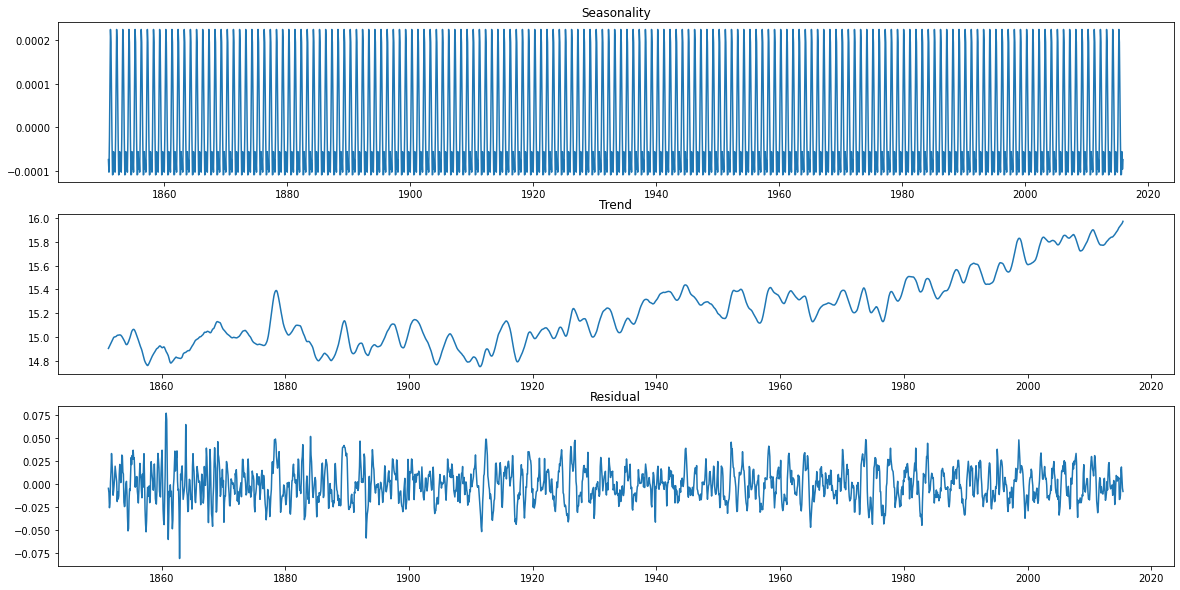

In [12]:
decomp = seasonal_decompose(gl_temp['LOMA_Temp'], model='additive', period=12)

fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].plot(decomp.seasonal)
ax[1].plot(decomp.trend)
ax[2].plot(decomp.resid)
ax[0].set_title('Seasonality')
ax[1].set_title('Trend')
ax[2].set_title('Residual')
plt.show()

After decomposing the graph we can see it does have pretty strong seasonality, it just has a very small effect on each value. Still, I'll do both seasonal and non-seasonal differencing and use a SARIMA model again. 

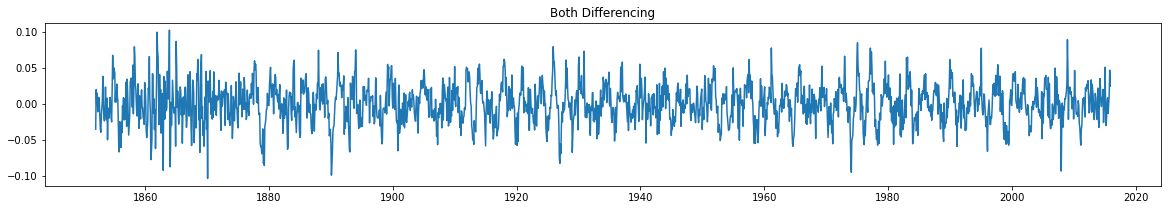

Stationarity Test Seasonal Differencing: Test Statistic   -1.320657e+01
p-value           1.067831e-24
Lags Used         2.500000e+01
Observations      1.942000e+03
dtype: float64


In [13]:
diff2 = gl_temp.diff().diff(12).dropna()

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(diff2.LOMA_Temp)
ax.set_title('Both Differencing')

plt.show()

result = adfuller(diff2['LOMA_Temp'])
adtest = pd.Series(result[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Observations'])

print('Stationarity Test Seasonal Differencing:', adtest)

This plot again looks like white noise and has a p-value much below 0.05, so it is stationary and I will now use the acf and pacf again to find the other parameter values.

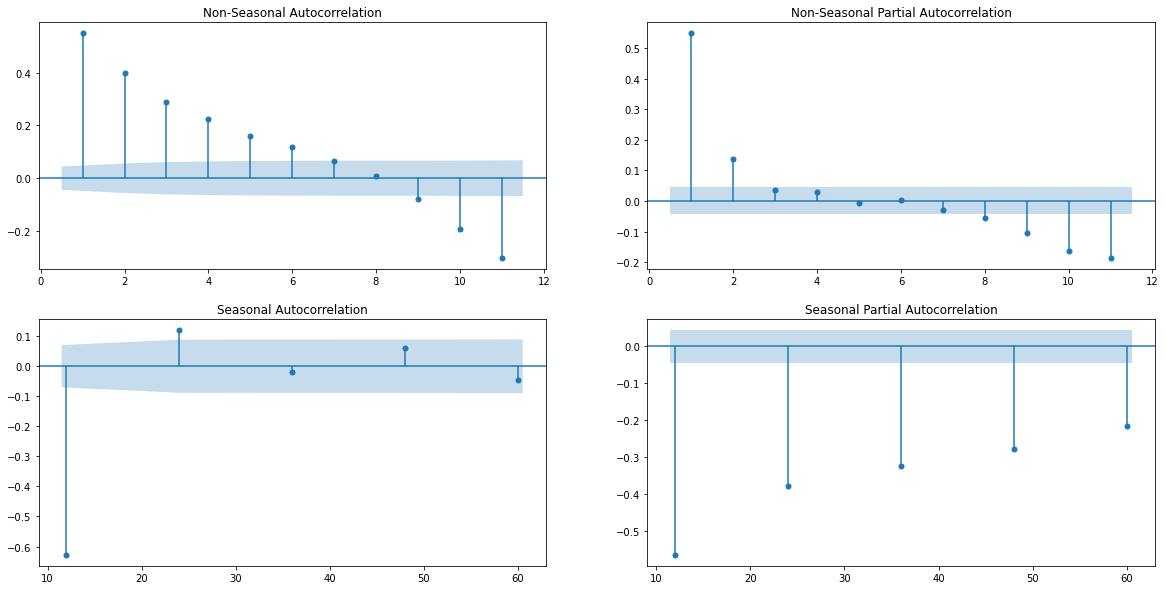

In [14]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))

plot_acf(diff2['LOMA_Temp'], lags=11, zero=False, alpha=0.05, title='Non-Seasonal Autocorrelation', ax=ax[0,0])
plot_pacf(diff2['LOMA_Temp'], lags=11, zero=False, alpha=0.05, title='Non-Seasonal Partial Autocorrelation', ax=ax[0,1])

plot_acf(diff2['LOMA_Temp'], lags=[12, 24, 36, 48, 60], zero=False, alpha=0.05, title='Seasonal Autocorrelation', ax=ax[1,0])
plot_pacf(diff2['LOMA_Temp'], lags=[12, 24, 36, 48, 60], zero=False, alpha=0.05, title='Seasonal Partial Autocorrelation', ax=ax[1,1])
plt.show()

Based on the non-seasonal plots this model will have both AR and MA parts in the non-seasonal component since both graphs taper off and neither one shuts off at a particular lag. Based on the seasonal plots, this model will have only a MA part in the seasonal component, and the value will be Q=2. I will try a couple different p and q values between 1 and 3 to find the best ones for this model.

In [15]:
order = (1, 1, 1) 
sorder = (0, 1, 2, 12)

sarimax = SARIMAX(gl_temp['LOMA_Temp'].loc['1975-04':], order=order, seasonal_order=sorder, exog=co2['CO2_Rolling'].loc[:'2015-12'])


t_model = sarimax.fit(maxiter=200)

t_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               LOMA_Temp   No. Observations:                  489
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                1548.527
Date:                                 Wed, 05 Jan 2022   AIC                          -3085.054
Time:                                         17:51:34   BIC                          -3060.061
Sample:                                     04-01-1975   HQIC                         -3075.226
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CO2_Rolling     0.0048      0.009      0.514      0.607      -0.013       0.023
ar.L1           0.8753      0.036     24.558      0.000       0.805       0.945
ma.L1          -0.4250      0.063     -6.729      0.000      -0.549      -0.301
ma.S.L12       -1.8919      0.052    -36.364      0.000      -1.994      -1.790
ma.S.L24        0.8981      0.044     20.387      0.000       0.812       0.984
sigma2       7.126e-05   6.04e-06     11.801      0.000    5.94e-05    8.31e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.64   Prob(JB):                         0.91
Heteroskedasticity (H):               1.00   Skew:                             0.00
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After some experimentation, the best model was (1,1,1)(0,1,2,12), which had the lowest AIC, and the best values for P>|z| (all under 0.05). Now let's look at the in-sample predictions and diagnostics to see if it's a good model.

Mean Absolute Percent Error: 0.0004356692774496208


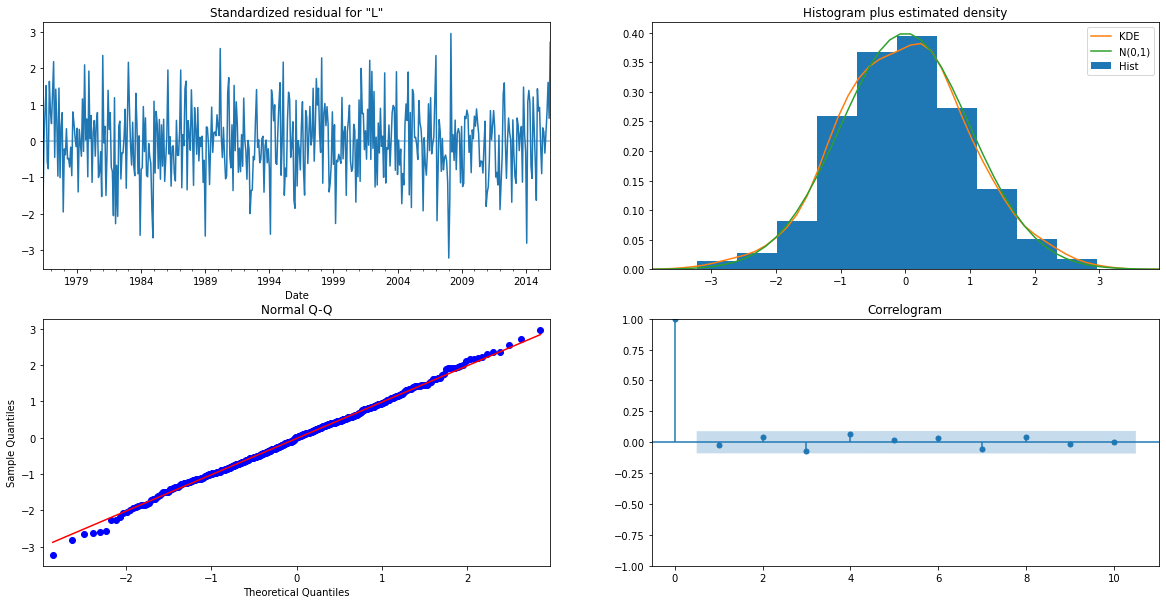

In [16]:
forecast = t_model.get_prediction(start=-240, exog=co2['CO2_Rolling'].loc[:'2015-12'])
fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, width=750, height=400, labels={'LOMA_Temp':'Temp. (C)'}, title='In-Sample Predictions')
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=forecast.predicted_mean.index, y=forecast.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.show()

acc = mape(forecast.predicted_mean, gl_temp['LOMA_Temp'].iloc[-240:])
print('Mean Absolute Percent Error:', acc)

t_model.plot_diagnostics(figsize=(20, 10))
plt.show()

The MAPE here is very low, just 0.04%, even lower than the CO2 model. The diagnostics also look good so I'm pretty confident in this model. Time to do some long term forecasting. 

In [17]:
fc_m = t_model.get_forecast(steps=303, exog=diff_co2_lvls['Forecast_Rolling'])

print('March 2041 Predicted Temp.:', round(fc_m.predicted_mean[-1], 3), 'Degrees Celsius')

fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, title='Predicted Global Average Temperature w/ Mean Predicted CO2 Levels', labels={'LOMA_Temp':'Temp. (C)'})
fig1.add_scatter(x=fc_m.predicted_mean.index, y=fc_m.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=fc_m.predicted_mean.index, y=fc_m.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=fc_m.predicted_mean.index, y=fc_m.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+1.5, pre_mn+1.5], mode='lines', name='1.5 Degree Increase')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+2, pre_mn+2], mode='lines', name='2 Degree Increase')
fig1.show()

March 2041 Predicted Temp.: 16.526 Degrees Celsius


Here is my prediction for the global land and ocean average temperatures through 2040 (starting in 2016). We can already see that this prediction has done well since the end of 2015. The rank of hottest years since then goes 2016, 2020, 2019, 2017, 2018, which is exactly the order this prediction gives with its spike in 2016 and dip in 2018.

This prediction uses the mean predicted CO2 levels from the earlier model, so this is essentially our most likely scenario. We can see that the mean prediction crosses the 1.5 degree threshold in late 2038. This is bad, but we shouldn't panic, there is still some time left to reduce emissions and get this back under control. We just have little room for error.

In [18]:
fc_u = t_model.get_forecast(steps=303, exog=diff_co2_lvls['UpBound_Rolling'])

print('March 2041 Predicted Temp.:', round(fc_u.predicted_mean[-1], 3), 'Degrees Celsius')

fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, title='Predicted Global Average Temperature w/ Upper Bound CO2 Levels', labels={'LOMA_Temp':'Temp. (C)'})
fig1.add_scatter(x=fc_u.predicted_mean.index, y=fc_u.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=fc_u.predicted_mean.index, y=fc_u.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=fc_u.predicted_mean.index, y=fc_u.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+1.5, pre_mn+1.5], mode='lines', name='1.5 Degree Increase')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+2, pre_mn+2], mode='lines', name='2 Degree Increase')
fig1.show()

March 2041 Predicted Temp.: 16.576 Degrees Celsius


Here is my second prediction, using the upper bound CO2 levels from the first model as the exogenous variable. We can see that the mean prediction crosses the 1.5 degree threshold about 21 months sooner than the previous graph. This shows that if we don't act fast enough, and let the carbon emission problem get worse, we'll only be sprinting faster towards disaster.

In [19]:
fc_l = t_model.get_forecast(steps=303, exog=diff_co2_lvls['LowBound_Rolling'])

print('March 2041 Predicted Temp.:', round(fc_l.predicted_mean[-1], 3), 'Degrees Celsius')

fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, title='Predicted Global Average Temperature w/ Lower Bound CO2 Levels', labels={'LOMA_Temp':'Temp. (C)'})
fig1.add_scatter(x=fc_l.predicted_mean.index, y=fc_l.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=fc_l.predicted_mean.index, y=fc_l.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=fc_l.predicted_mean.index, y=fc_l.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+1.5, pre_mn+1.5], mode='lines', name='1.5 Degree Increase')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+2, pre_mn+2], mode='lines', name='2 Degree Increase')
fig1.show()

March 2041 Predicted Temp.: 16.475 Degrees Celsius


Here is my thrid prediction, using the lower bound CO2 predictions from the first model. Even in this scenario, we just barely cross the 1.5 degree threshold by the end of 2040. Though this suggests we're still on track for the threshold, it shows that even small differences in CO2 emissions now can add up in the future. 

In [20]:
fc_so = t_model.get_forecast(steps=303, exog=diff_co2_lvls['SO_Rolling'])

print('March 2041 Predicted Temp.:', round(fc_so.predicted_mean[-1], 3), 'Degrees Celsius')

fig1 = px.line(gl_temp, x=gl_temp.index, y=gl_temp.LOMA_Temp, title='Predicted Global Average Temperature w/ Flat CO2 Levels', labels={'LOMA_Temp':'Temp. (C)'})
fig1.add_scatter(x=fc_so.predicted_mean.index, y=fc_so.predicted_mean, mode='lines', name='Predicted')
fig1.add_scatter(x=fc_so.predicted_mean.index, y=fc_so.conf_int().iloc[:,0], name='Lower Bound')
fig1.add_scatter(x=fc_so.predicted_mean.index, y=fc_so.conf_int().iloc[:,1], fill='tonexty', name='Upper Bound')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+1.5, pre_mn+1.5], mode='lines', name='1.5 Degree Increase')
fig1.add_scatter(x=['1850-12-01', '2041-03-01'], y=[pre_mn+2, pre_mn+2], mode='lines', name='2 Degree Increase')
fig1.show()


March 2041 Predicted Temp.: 16.285 Degrees Celsius


Finally, I made a prediction with a purely hypothetical scenario in which CO2 emissions stay perfectly constant at 420 ppm once they hit that point. For reference, the current 12 month rolling average is 414.83 ppm (as of March 2021). As you can see, that makes a massive impact in the temperatue, with the upper bound barely even reaching the 1.5 degree threshold. This goes to show that making efforts to significantly reduce CO2 emissions will pay off in the long run. 

Of course, this particular scenario is essentially impossible, but the message remains. It's not too late to do something.

This leads us to our next, more daunting question, what happens if we don't? I'll try my best to answer that question in my next notebook where I will analyze sea level change and natural disaster frequency, particularly in the United States.

In [21]:
pred_temps = pd.DataFrame()

pred_temps['Mean_Predicted'] = fc_m.predicted_mean
pred_temps['Upper_Mean'] = fc_u.predicted_mean
pred_temps['Lower_Mean'] = fc_l.predicted_mean
pred_temps['Highest_Bound'] = fc_u.conf_int().iloc[:,1]
pred_temps['Lowest_Bound'] = fc_l.conf_int().iloc[:,0]
pred_temps['SO_Mean'] = fc_so.predicted_mean

pred_temps.to_csv('PredTemps2040.csv', index=True)

I'll save a few different temperature predictions to use as an exogenous variable in my next notebook.

# Part II

See the follow up notebook [here](https://www.kaggle.com/jedbell/climate-analysis-ii-what-impact).
